In [1]:
from sklearn.datasets import load_iris
import numpy as np
import math
from tqdm import tqdm
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import pandas as pd
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    OrdinalEncoder,
)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, ConfusionMatrixDisplay, confusion_matrix

In [2]:
model = LogisticRegression(C=0.5)

In [3]:
iden = pd.read_csv('train_identity.csv')

In [4]:
trans = pd.read_csv('train_transaction.csv')

In [5]:
joined = trans.merge(iden,how='left')

In [6]:
del iden

In [7]:
del trans

In [8]:
joined = joined[joined['TransactionDT'].notnull()]

In [9]:
joined = joined[joined['isFraud'].notnull()]

In [10]:
limite = np.percentile(joined['TransactionDT'], 80)

In [11]:
limite

12192853.600000001

In [12]:
filtro1 = joined['TransactionDT'] > limite

In [13]:
filtro1.value_counts()

False    472432
True     118108
Name: TransactionDT, dtype: int64

In [14]:
validation = joined[filtro1]

In [15]:
filtro2 = joined['TransactionDT']<= limite

In [16]:
train = joined[filtro2]

In [17]:
label = train[['isFraud']]

In [18]:
del(train['isFraud'])

In [19]:
del(train['TransactionID'])

In [20]:
entrenando = train.copy()

In [21]:
del joined

In [22]:
dict_one_hot = {}

In [23]:
def one_hot_encode(df, columna, dict_one_hot):
    if columna not in dict_one_hot:
        dict_one_hot[columna] = OneHotEncoder(handle_unknown='ignore')
        dict_one_hot[columna].fit_transform(df[[columna]].astype(str)).astype(int)
    col_encoded = (dict_one_hot[columna].transform(df[[columna]].astype(str)).astype(int))
    col_encoded = pd.DataFrame(col_encoded.todense()).add_prefix(columna + '_').fillna(0)
    del(df[columna])
    df_nuevo = pd.concat([df.reset_index(drop=True), col_encoded], axis=1)
    return df_nuevo

In [24]:
train = one_hot_encode(train,'id_34',dict_one_hot)

In [25]:
train = one_hot_encode(train,'id_35',dict_one_hot)

In [26]:
train = one_hot_encode(train,'id_38',dict_one_hot)

In [27]:
train = one_hot_encode(train,'ProductCD',dict_one_hot)

In [28]:
train = one_hot_encode(train,'card4',dict_one_hot)

In [29]:
train = one_hot_encode(train,'P_emaildomain',dict_one_hot)

In [30]:
le = {} #genero diccionario por columna para tener un labelEnc por col
for column in train.columns:
    if train[column].dtypes==object:
        le[column] = OrdinalEncoder(handle_unknown='ignore')
        train[column] = le[column].fit_transform(train[column].astype(str).values.reshape(-1, 1))

In [31]:
train.fillna(-1,inplace=True)

In [32]:
model.fit(train, label)

C:\Users\julip\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\julip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.5)

In [33]:
print(classification_report(label, model.predict(train)))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98    455833
           1       0.20      0.00      0.00     16599

    accuracy                           0.96    472432
   macro avg       0.58      0.50      0.49    472432
weighted avg       0.94      0.96      0.95    472432



In [34]:
roc_auc_score(label, model.predict_proba(train)[:,1])

0.6408552550876726

### VALIDATION

In [35]:
validation.head(2)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
472432,3459432,1,12192900,33.261,C,9300,103.0,185.0,visa,138.0,...,chrome 65.0,NaN,NaN,NaN,F,F,T,F,desktop,NaN
472433,3459433,0,12192911,52.811,C,8809,179.0,106.0,visa,137.0,...,chrome generic for android,NaN,NaN,NaN,F,F,T,F,mobile,F3311


In [36]:
label2=validation['isFraud']

In [37]:
del(validation['isFraud'])

In [38]:
del(validation['TransactionID'])

In [39]:
validation = one_hot_encode(validation,'id_34',dict_one_hot)

In [40]:
validation = one_hot_encode(validation,'id_35',dict_one_hot)

In [41]:
validation = one_hot_encode(validation,'id_38',dict_one_hot)

In [42]:
validation = one_hot_encode(validation,'ProductCD',dict_one_hot)

In [43]:
validation = one_hot_encode(validation,'card4',dict_one_hot)

In [44]:
validation = one_hot_encode(validation,'P_emaildomain',dict_one_hot)

In [45]:
for column in validation.columns:
    if validation[column].dtype==object:
        validation[column] = le[column].transform(validation[column].astype(str).values.reshape(-1, 1))


In [46]:
validation.fillna(-1,inplace=True)

In [47]:
print(classification_report(label2, model.predict(validation)))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98    114044
           1       0.00      0.00      0.00      4064

    accuracy                           0.96    118108
   macro avg       0.48      0.50      0.49    118108
weighted avg       0.93      0.96      0.95    118108



In [48]:
roc_auc_score(label2, model.predict_proba(validation)[:,1])

0.6944613620602851

### TEST

In [49]:
idenTest = pd.read_csv('test_identity.csv')

In [50]:
transTest = pd.read_csv('test_transaction.csv')

In [51]:
idenTest.columns

Index(['TransactionID', 'id-01', 'id-02', 'id-03', 'id-04', 'id-05', 'id-06',
       'id-07', 'id-08', 'id-09', 'id-10', 'id-11', 'id-12', 'id-13', 'id-14',
       'id-15', 'id-16', 'id-17', 'id-18', 'id-19', 'id-20', 'id-21', 'id-22',
       'id-23', 'id-24', 'id-25', 'id-26', 'id-27', 'id-28', 'id-29', 'id-30',
       'id-31', 'id-32', 'id-33', 'id-34', 'id-35', 'id-36', 'id-37', 'id-38',
       'DeviceType', 'DeviceInfo'],
      dtype='object')

In [52]:
def renombrar(df):
    for columna in df.columns:
        if columna.startswith('id'):
            ss = columna.split('-')
            df.rename(columns={columna:ss[0]+'_'+ss[1]},inplace=True)
    return (df)
        

In [53]:
idenTest = renombrar(idenTest)

In [54]:
idenTest.columns

Index(['TransactionID', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06',
       'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14',
       'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22',
       'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30',
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object')

In [55]:
test = transTest.merge(idenTest,how='left')

In [56]:
ids = test[['TransactionID']]

In [57]:
del(test['TransactionID'])

In [58]:
test.head(2)

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,170.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,299.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
test = one_hot_encode(test,'id_34',dict_one_hot)

In [60]:
test = one_hot_encode(test,'id_35',dict_one_hot)

In [61]:
test = one_hot_encode(test,'id_38',dict_one_hot)

In [62]:
test = one_hot_encode(test,'ProductCD',dict_one_hot)

In [63]:
test = one_hot_encode(test,'P_emaildomain',dict_one_hot)

In [64]:
test = one_hot_encode(test,'card4',dict_one_hot)

In [65]:
for column in test.columns:
    if test[column].dtype==object:
        test[column] = le[column].transform(test[column].astype(str).values.reshape(-1, 1))

In [66]:
test.fillna(-1,inplace=True)

In [67]:
test.head(2)

,TransactionDT,TransactionAmt,card1,card2,card3,card5,card6,addr1,addr2,dist1,...,P_emaildomain_55,P_emaildomain_56,P_emaildomain_57,P_emaildomain_58,P_emaildomain_59,card4_0,card4_1,card4_2,card4_3,card4_4
0,18403224,31.95,10409,111.0,150.0,226.0,2.0,170.0,87.0,1.0,...,0,0,0,0,0,0,0,0,0,1
1,18403263,49.00,4272,111.0,150.0,226.0,2.0,299.0,87.0,4.0,...,0,0,0,0,0,0,0,0,0,1


In [68]:
sub = pd.read_csv('sample_submission.csv')

In [69]:
sub.head(2)

,TransactionID,isFraud
0,3663549,0.5
1,3663550,0.5


In [70]:
prediccionModel = model.predict_proba(test)[:,1]

In [71]:
#test = test[['predict']]

In [72]:
#join = ids.join(test,how='outer')

In [73]:
#join

## Hiperparametros
Utilice RandomizedSearch de *Sklearn* para buscar los hiperparametros que mejoraron mi aucroc.

In [74]:
"""from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
logistic = LogisticRegression(tol=1e-2, max_iter=1000,
                              random_state=0)
distributions = dict(C=[0.1,0.2,0.12,0.5,0.67,0.8,1],
                     penalty=['l2','l1'], solver=['lbfgs', 'saga', 'liblinear', 'sag'])
clf = RandomizedSearchCV(logistic, distributions, scoring='roc_auc',n_jobs=1, verbose=100, cv=3,n_iter=4, random_state=0)
search = clf.fit(train, label)
search.best_params_"""

"from sklearn.linear_model import LogisticRegression\nfrom sklearn.model_selection import RandomizedSearchCV\nfrom scipy.stats import uniform\nlogistic = LogisticRegression(tol=1e-2, max_iter=1000,\n                              random_state=0)\ndistributions = dict(C=[0.1,0.2,0.12,0.5,0.67,0.8,1],\n                     penalty=['l2','l1'], solver=['lbfgs', 'saga', 'liblinear', 'sag'])\nclf = RandomizedSearchCV(logistic, distributions, scoring='roc_auc',n_jobs=1, verbose=100, cv=3,n_iter=4, random_state=0)\nsearch = clf.fit(train, label)\nsearch.best_params_"

In [75]:
"""import pickle
with open('model_backup', 'wb') as model_backup_file:
    pickle.dump(search, model_backup_file)"""

"import pickle\nwith open('model_backup', 'wb') as model_backup_file:\n    pickle.dump(search, model_backup_file)"

In [76]:
import pickle
with open('model_backup', 'rb') as file:
    search = pickle.load(file)

### Train

In [77]:
print(classification_report(label, search.predict(train)))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98    455833
           1       0.30      0.01      0.03     16599

    accuracy                           0.96    472432
   macro avg       0.63      0.51      0.50    472432
weighted avg       0.94      0.96      0.95    472432



In [78]:
roc_auc_score(label, search.predict_proba(train)[:,1])

0.7344186927679233

### Validation

In [79]:
print(classification_report(label2, search.predict(validation)))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98    114044
           1       0.31      0.02      0.03      4064

    accuracy                           0.96    118108
   macro avg       0.64      0.51      0.51    118108
weighted avg       0.94      0.96      0.95    118108



In [80]:
roc_auc_score(label2, search.predict_proba(validation)[:,1])

0.7469679237113068

### Test

In [81]:
prediccionHiperparametros= search.predict_proba(test)[:,1]

In [82]:
test['prediccionModel'] = prediccionModel

In [83]:
test['prediccionModelHiperparametros'] = prediccionHiperparametros

In [84]:
test = test[['prediccionModelHiperparametros']]

In [85]:
join = ids.join(test)

In [86]:
join.rename(columns={'prediccionModelHiperparametros':'isFraud'},inplace=True)

In [87]:
join

,TransactionID,isFraud
0,3663549,0.013047
1,3663550,0.018249
2,3663551,0.031613
3,3663552,0.026399
4,3663553,0.025883
...,...,...
506686,4170235,0.034908
506687,4170236,0.533141
506688,4170237,0.026936
506689,4170238,0.030755


In [88]:
join.to_csv("entregaKaggle.csv", index = False)

https://www.kaggle.com/c/ieee-fraud-detection/submit

<img src = 'scoreKaggle.png' alt = "title">

In [89]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
fs = SelectFromModel(RandomForestClassifier(n_estimators=200), max_features=5)

In [90]:
importance = search.best_estimator_.coef_[0]

In [91]:
from matplotlib import pyplot
import numpy as np

In [92]:
for i,v in enumerate(importance):
    print('Feature: %0d, score: %.5f' %(i,v))


Feature: 0, score: 0.00000
Feature: 1, score: 0.00005
Feature: 2, score: -0.00005
Feature: 3, score: -0.00074
Feature: 4, score: -0.00026
Feature: 5, score: -0.00050
Feature: 6, score: -0.00001
Feature: 7, score: -0.00096
Feature: 8, score: -0.00031
Feature: 9, score: 0.00001
Feature: 10, score: 0.00008
Feature: 11, score: -0.00007
Feature: 12, score: 0.00014
Feature: 13, score: 0.00021
Feature: 14, score: -0.00000
Feature: 15, score: 0.00005
Feature: 16, score: -0.00004
Feature: 17, score: 0.00001
Feature: 18, score: 0.00006
Feature: 19, score: 0.00010
Feature: 20, score: -0.00003
Feature: 21, score: 0.00007
Feature: 22, score: 0.00007
Feature: 23, score: 0.00010
Feature: 24, score: -0.00017
Feature: 25, score: -0.00003
Feature: 26, score: -0.00055
Feature: 27, score: -0.00059
Feature: 28, score: -0.00012
Feature: 29, score: -0.00043
Feature: 30, score: -0.00016
Feature: 31, score: 0.00002
Feature: 32, score: -0.00004
Feature: 33, score: -0.00022
Feature: 34, score: 0.00000
Feature: 3

In [93]:
prom = train.mean().values

In [94]:
imporEscalado = abs(importance/prom)

In [95]:
ordenada = np.argsort(imporEscalado)[::-1]

In [96]:
ordenada

array([212, 211,  52, 486, 123,  56, 210,  83,  81,  67, 318,  66,  80,
        98, 130,  55,  82,  51, 121, 122, 142, 476,  58, 414,  71,  65,
       109, 129,  64, 141, 107,  57,  97,  70, 128, 134, 464, 447, 120,
       113, 220, 322, 493, 278, 267, 143, 317, 316, 383, 106,  50, 497,
       406, 315, 307, 271, 255, 380, 279, 236, 219, 108, 268, 306, 133,
       499, 250, 467, 217, 503, 150, 281, 248, 469, 227, 465, 270, 324,
       382, 249, 277, 225, 295, 330, 282, 266, 386, 112, 320, 502, 101,
       239,  89,  38, 473, 308,  14, 426, 409, 260, 413, 321, 152, 228,
       216, 280,  94,  23, 292, 254, 381, 388, 474, 500, 455, 293, 100,
        32, 238, 393, 144,  88,  39, 291, 475,  93, 485, 495, 226, 256,
       235,  19, 237, 323, 118,  18, 387, 312,  92, 119, 139, 477, 259,
       140, 442, 294, 480,  87, 453, 483, 389,  78, 368, 384, 488, 460,
        79, 310, 487, 491, 151, 484, 262, 496,  13, 498, 431,  91, 345,
       437, 184, 146, 490,  33, 439, 364, 358,  21, 454, 350,  9

In [97]:
top_10 = imporEscalado[ordenada][:10]

In [98]:
top_10

array([8.56477199e-03, 2.65268198e-04, 1.93272457e-04, 1.79664502e-04,
       1.77774552e-04, 1.76305507e-04, 1.66980085e-04, 1.04225774e-04,
       1.01044192e-04, 9.96859717e-05])

In [99]:
cols =  train.columns[ordenada[:10]]

In [100]:
cols

Index(['V163', 'V162', 'V3', 'P_emaildomain_39', 'V74', 'V7', 'V161', 'V34',
       'V32', 'V18'],
      dtype='object')

In [101]:
import seaborn as sns

In [102]:
df = pd.DataFrame({'features':cols,'values': top_10}) 

Text(0.5, 0, 'Feature')

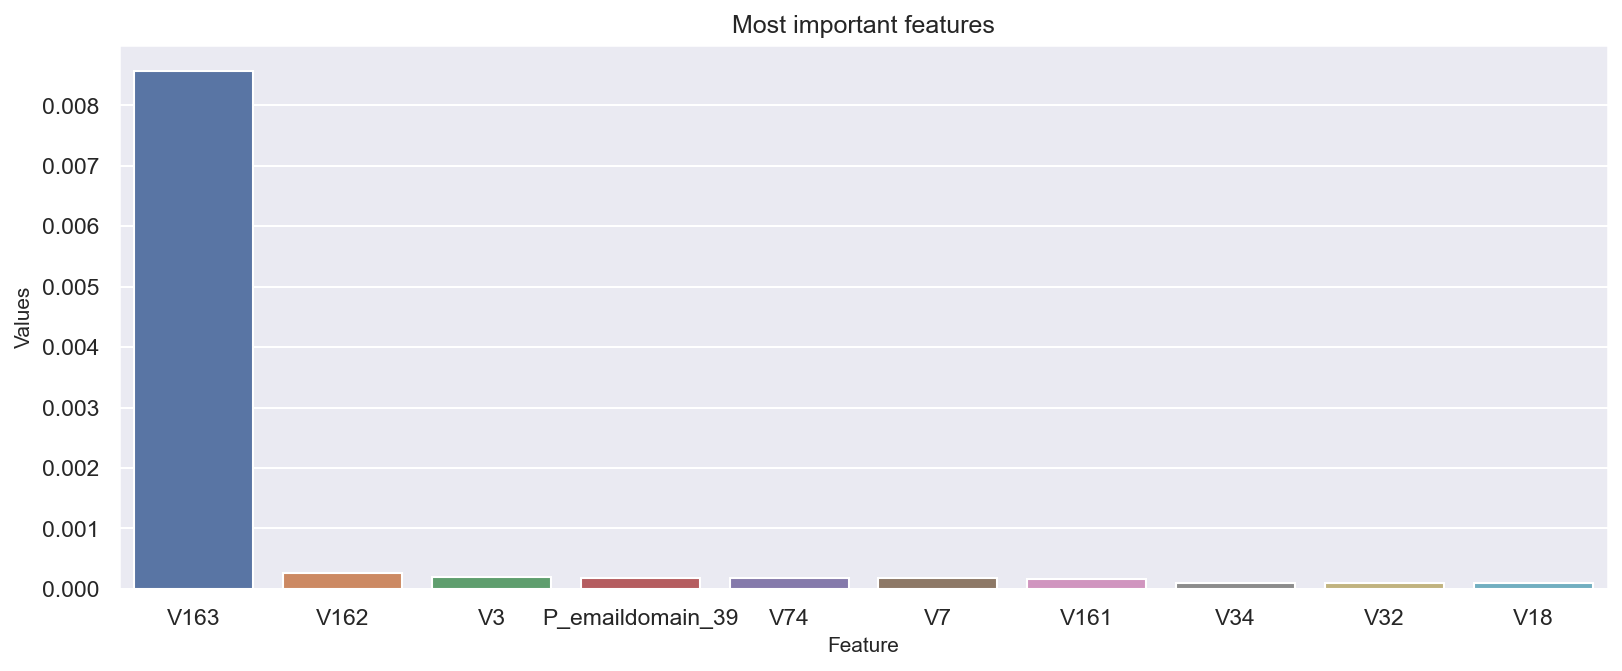

In [103]:
sns.set(rc={"figure.dpi":150})
sns.set(rc = {'figure.figsize':(12.8,4.8)})
ax = sns.barplot(x="features", y="values", data=df)
ax.set_title('Most important features',size =12)
ax.set_ylabel('Values', fontsize = 10)
ax.set_xlabel('Feature', fontsize = 10)